In [23]:
#######################
### L03 - Exercises ###
#######################

# importing libraries and setting up nice plots

import random
import numpy                    as     np
import matplotlib.pyplot        as     plt
import matplotlib.patches       as     patches
import matplotlib.ticker		as     tck
import matplotlib.colors		as     colors
from   matplotlib				import rc
from   matplotlib.gridspec		import GridSpec
from   scipy.stats              import norm, poisson

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif" : ["Times New Roman"],
	"font.size"  : 10,
    "figure.dpi" : 300
    })
plt.rc('text.latex', preamble=r'\usepackage{amssymb}')



In [24]:
#################################################
### L03 - Exercise 1: Monte Carlo integration ###
#################################################

Using Monte Carlo Integration, verify that:

$$
    I = 
    \int_0^\infty 
    \, \textup{d}x 
    \; x^3 \exp\!\!\bigg( \!\!
        -\frac{1}{2} \frac{x^2}{\sigma^2}
    \bigg)
    = 2 \sigma^4
$$

Our goal is to write the integral as:

$$
    I = \int_0^\infty 
    \, \textup{d}x 
    \; f(x) \, \textup{pdf}(x)
$$

We recognise something similar to a zero-mean Normal distribution $\mathcal{N}(\mu = 0,\sigma)$ in the exponential factor. However, the integration domain is $(0,+\infty)$, so we must take as $\textup{pdf}(x)$ a truncated Normal distribution only for $x \geq 0$. Note that the area of such a truncated Normal is only $\frac{1}{2}$, so the pdf must be re-normalised:


$$
\textup{pdf}(x) 
= \begin{cases}
    2\,\dfrac{1}{\sigma \sqrt{2\pi}} 
  \exp\!\!\bigg( \!\!
        -\dfrac{1}{2} \dfrac{x^2}{\sigma^2}
  \bigg)
  & \textup{ if } x \geq 0
  \\
  0 & \textup{ if } x < 0
\end{cases} 
$$ 

$$
% \mathcal{N}(\mu = 0,\sigma)
% = \frac{1}{\sigma \sqrt{2\pi}} 
%   \exp\!\!\bigg( \!\!
%         -\frac{1}{2} \frac{x^2}{\sigma^2}
%   \bigg)
$$

so that the function $f(x)$ becomes

$$
f(x) = \sigma \sqrt{\dfrac{\pi}{2}} \, x^3
$$

With Monte Carlo integration we then define the following unbiased estimator for $I$:

$$
    I \approx \bar{I} =
    \frac{ 1 }{N} \sum_{i\,=\,1}^N f(x_i)
    = \sqrt{\frac{\pi}{2}}
    \frac{ \sigma }{N} \,\sum_{i\,=\,1}^N x_i^3 
    \quad \textup{with } x_i \textup{ drawn from } % \quad 
    \textup{pdf}(x)
    % \mathcal{N}(\mu = 0,\sigma)
$$

As this is also the definition of sample arithmetic mean, we can assign an error to this estimator using the (sample) standard deviation of the mean:

$$
    \sigma_{\bar{I}} \approx \sqrt{ \frac{1}{N} } \, \sqrt{ 
        \frac{ 1 }{N-1} \sum_{i\,=\,1}^N \big( f(x_i) - \bar{I} \big)^2
    }
   \quad \textup{with } x_i \textup{ drawn from } % \quad 
    \textup{pdf}(x)
    % \mathcal{N}(\mu = 0,\sigma)
    \quad \textup{that decreases as } N^{-1/2} \textup{ for large } N

$$

Where the only non trivial consideration is that the sum grows as $N$. 

Note also that the uncertainty on $ \sigma_{\bar{I}} $ is:

$$
\sigma_{\sigma_{\bar{I}}} = \sigma_{\bar{I}} \, \sqrt{ \frac{1}{2(N-1)} }  
% = \sqrt{ \frac{1}{N} } \,\sqrt{ \frac{1}{2(N-1)} } \, \sqrt{ 
%        \frac{ 1 }{N-1} \sum_{i\,=\,1}^N \big( f(x_i) - \bar{I} \big)^2
%    }
%\quad \textup{with } x_i \textup{ drawn from } % \quad 
%    \textup{pdf}(x)
\quad \textup{that decreases as } N^{-1} \textup{ for large } N
$$

In [25]:
# let us take different orders of magnitude for N:

N = [ int(1e4), int(1e5), int(1e6), int(1e7), int(1e8) ]

# above, we have rewritten the integrand as f * pdf

# use an intermediate pdf, a Gaussian distr centered in 0 with non0 sigma
sigma = 1
mean  = 0
distr_gauss = norm(mean,sigma)

# extract a sample x of size N from the Gaussian distr
# note: the integral domain is (0, +infty)
#       the Gaussian distr domain is (-infty, +infty)
#       the Gaussian distr is symmetric
# then let's take the absolute value of x sampled from the usual Gaussian
# remember to correct for the wrong normalisation
# evaluate the function f on the sample x, then approx mean(f)


I_tru = 2 * sigma**4

print("Analytic integral = {:.10f}".format(I_tru))

I_avg = np.zeros(len(N))
I_std = np.zeros(len(N))
I_q50 = np.zeros(len(N))
I_q84 = np.zeros(len(N))
I_q16 = np.zeros(len(N))

# for each value of N run a Monte-Carlo estimate of the integral:
for j, n in enumerate(N):
    # extract n numbers x_i with pdf defined above, interval = (-\infty,+\infty)
    x = np.array( distr_gauss.rvs(n) )   
    # take their absolute values |x_i| so that interval = positive real numbers
    x = np.abs(x)   
    # for each value x_i compute f(x_i)                     
    f = sigma * np.sqrt(np.pi/2) * x**3  
    # the arithmetic mean of f(x_i) is the Monte-Carlo(n) estimator of the true integral
    m = np.mean(f)
    I_avg[j] = m
    # as error on this estimate we can use the (sample) standard deviation of the mean
    e = np.std(f, ddof=1) / np.sqrt(n)
    I_std[j] = e
    # alternatively, let us compute the 16% & 84% quantiles and the median (50% quantile)
    q16, q50, q84 = np.quantile(f, [0.16, 0.50, 0.84])
    I_q16[j] = q16
    I_q50[j] = q50
    I_q84[j] = q84
    # print results
    print(
        "N = {:.0e} Monte Carlo integral = {:.6f} +- {:.6f}   ;   (16%, 50%, 84%) quantiles = ({:.6f},{:.6f},{:.6f})"
        .format(float(n), m, e, q16, q50, q84)
        )




Analytic integral = 2.0000000000
N = 1e+04 Monte Carlo integral = 1.992098 +- 0.044706   ;   (16%, 50%, 84%) quantiles = (0.009443,0.368495,3.384370)
N = 1e+05 Monte Carlo integral = 2.008559 +- 0.014109   ;   (16%, 50%, 84%) quantiles = (0.010642,0.382303,3.465299)
N = 1e+06 Monte Carlo integral = 2.002011 +- 0.004423   ;   (16%, 50%, 84%) quantiles = (0.010408,0.383866,3.478138)
N = 1e+07 Monte Carlo integral = 1.998911 +- 0.001398   ;   (16%, 50%, 84%) quantiles = (0.010304,0.384366,3.474934)
N = 1e+08 Monte Carlo integral = 1.998919 +- 0.000442   ;   (16%, 50%, 84%) quantiles = (0.010307,0.384621,3.475950)


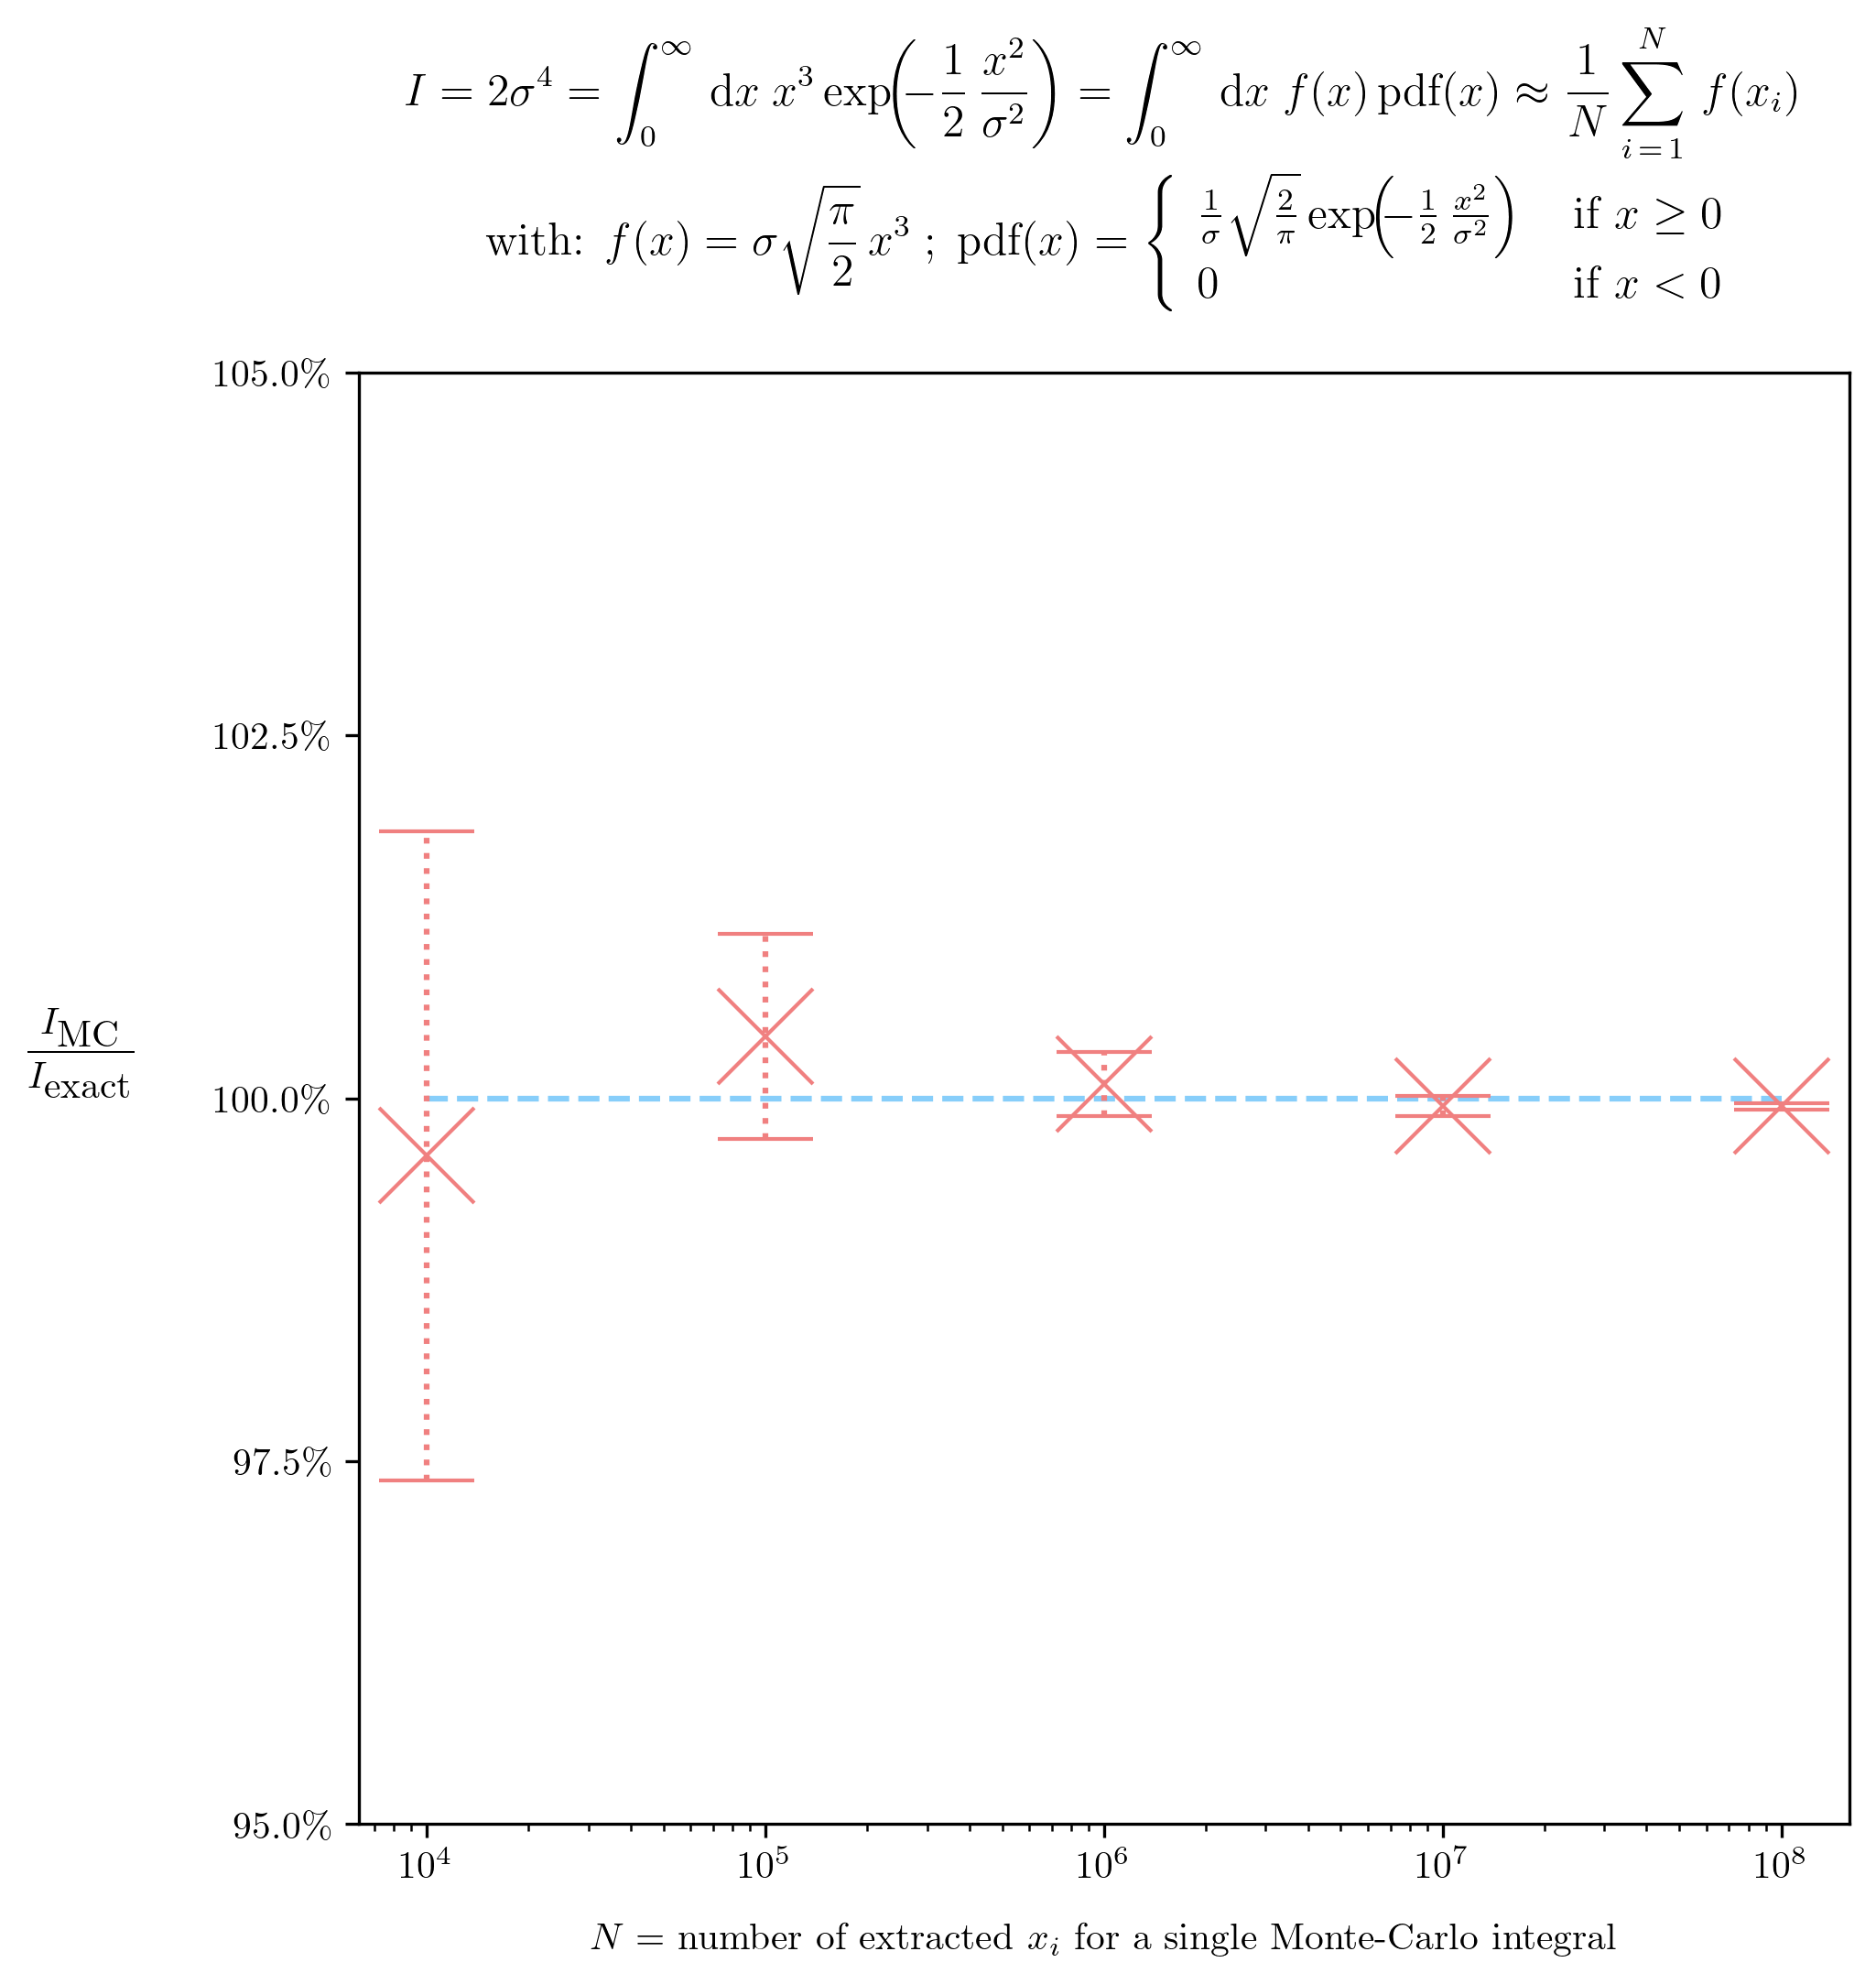

In [26]:
# let us plot the Monte Carlo estimates for the integral

fig , ax = plt.subplots(1,1, figsize=(7,7))

ax.set_xscale('log')
# ax.set_yscale('log')

# just a LaTeX title with the recap of what we did
latex_1 = (
    r"$$" 
    + r" I = 2 \sigma^4 "
    + r" = \int_0^\infty \,\textup{d}x \; x^3 \exp\!\! \left( \!\! -\frac{1}{2} \, \frac{x^2}{\sigma^2} \right)"
    + r" = \int_0^\infty \,\textup{d}x \; f(x) \, \textup{pdf}(x) "
    + r" \approx \frac{1}{N} \sum_{i\,=\,1}^N \, f(x_i)"
    + r"$$"
    + "\n" 
    + r"$$"
    + r"\textup{with: }"
    + r" f(x) = \sigma \sqrt{ \frac{\pi}{2} } \, x^3 "
    + r" \; ; \; "
    + r" \textup{pdf}(x) = "
    + r" \left\{ \begin{array}{ll} "
    + r" \frac{1}{\sigma} \sqrt{ \frac{2}{\pi} } \exp\!\!\left( \!\! -\frac{1}{2} \, \frac{x^2}{\sigma^2} \right) "
    + r" & \textup{ if } x \geq 0 "
    + r" \\ 0 "
    + r" & \textup{ if } x < 0 "
    + r" \end{array} \right." 
    + r"$$"
    +"\n"
)
ax.set_title(latex_1)

# for an easy comparison, just normalize the monte carlo results and their errors 
# to the true value of the integral
i_avg = I_avg / I_tru
i_std = I_std / I_tru

ax.hlines(1, xmin=1e4, xmax=1e8, ls='--', color='lightskyblue')

ax.plot(N,I_avg/I_tru, ls='', marker='x', ms=25, color='lightcoral')
ax.plot(N,i_avg+i_std, ls='', marker='_', ms=25, color='lightcoral')
ax.plot(N,i_avg-i_std, ls='', marker='_', ms=25, color='lightcoral')
ax.vlines(N, ymin=i_avg-i_std, ymax=i_avg+i_std, ls=':', color='lightcoral')

'''
NN = np.array(N) * 1.05
ax.plot(NN,i_q50, ls='', marker='x', color='khaki')
ax.plot(NN,i_q84, ls='', marker='_', color='khaki')
ax.plot(NN,i_q16, ls='', marker='_', color='khaki')
ax.vlines(NN, ymin=i_q16, ymax=i_q84, ls=':', color='khaki')
'''

ax.set_ylim(0.95,1.05)
ax.yaxis.set_major_locator(tck.MultipleLocator(0.025))
ax.yaxis.set_major_formatter(tck.PercentFormatter(xmax=1.0, decimals=1))

ax.set_xlabel('$N=$ number of extracted $x_i$ for a single Monte-Carlo integral', labelpad=10)
ax.set_ylabel(r'$$ \frac{ I_{\textup{MC}} }{ I_{\textup{exact}} } $$', rotation='horizontal', labelpad=35)

fig.savefig('./L03_images/L03_Monte-Carlo.pdf', bbox_inches='tight')



The plot above shows that the the Monte-Carlo integral converges to the real value. Nice.

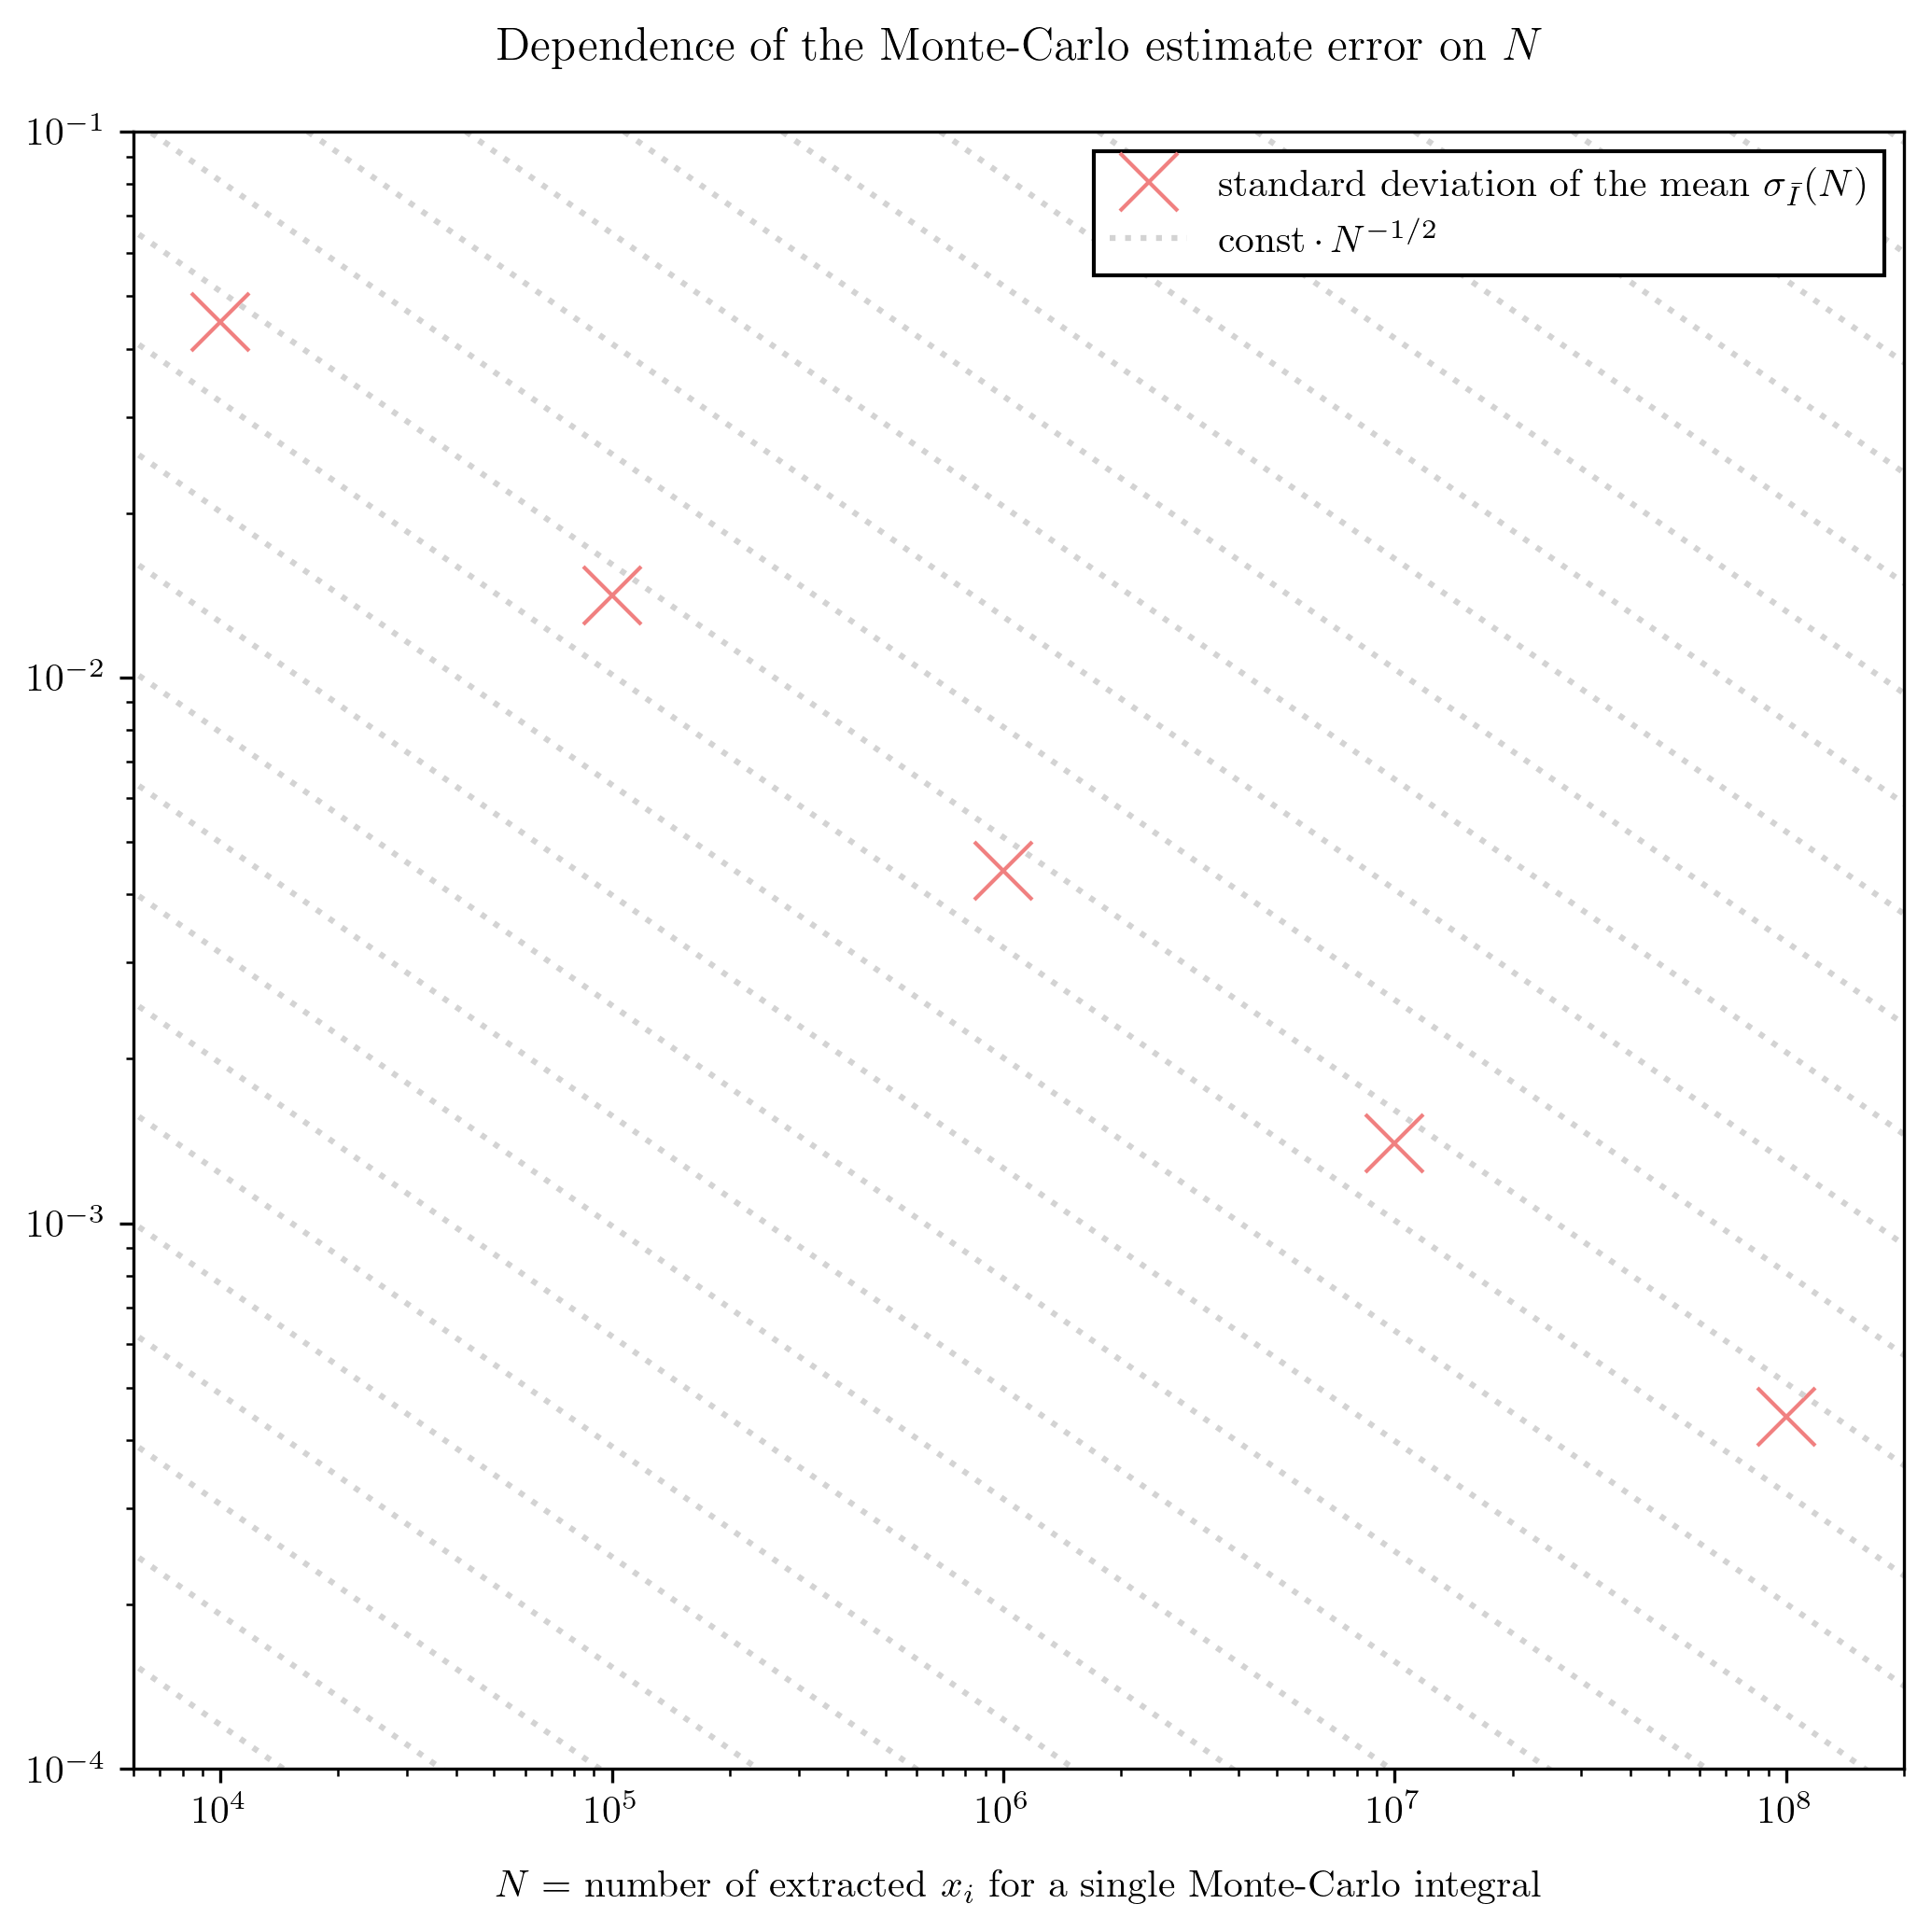

In [47]:
# To study (qualitatively) how good the Monte Carlo approximation is,
# let us plot the dependence of its uncertainty with N, as we as expressed above in formulae

fig , ax = plt.subplots(1,1, figsize=(7,7))

I_sst = I_std / np.sqrt(2*(n-1))

# labelin_1 = r'$$ \sigma_{\bar{I}}(N) = \frac{s(N)}{\sqrt{N_{\textup{mc}}}} = \frac{1}{\sqrt{N_{\textup{mc}}}}\frac{1}{N-1}\sum_{i=1}^N (I_i-\bar{I})^2 $$' #\, \sqrt{N_{\textup{mc}}}

ax.set_title('Dependence of the Monte-Carlo estimate error on $N$'+'\n')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(6e3,2e8)
ax.set_ylim(1e-4,1e-1)

ax.plot(N, I_std, ls='', marker='x', ms=15, color='lightcoral', label=r'standard deviation of the mean $\sigma_{\bar{I}}(N)$')
# ax.plot(N,I_std+I_sst, ls='', marker='_', ms=25, color='lightcoral')
# ax.plot(N,I_std-I_sst, ls='', marker='_', ms=25, color='lightcoral')
# ax.vlines(N, ymin=I_std-I_sst, ymax=I_std+I_sst, ls='-', color='lightcoral')

ax.set_xlabel('$N=$ number of extracted $x_i$ for a single Monte-Carlo integral', labelpad=10)


xn = np.logspace(3.5,8.5,1000)
beta = np.linspace(-10,10.,100)
for b in beta:
    fn = xn**(-1/2) * 10**b
    ax.plot(xn, fn, color='lightgrey', ls=':')
ax.plot(xn, fn, color='lightgrey', ls=':', label=r'const$ \, \cdot \, N^{-1/2}$')




ax.legend(frameon=True, framealpha=1, fancybox=False, edgecolor='black', loc=1)


fig.tight_layout()
fig.savefig('./L03_images/L03_Monte-Carlo__std.pdf', bbox_inches='tight')




We find that: 
$$ 
    \log_{10}( \sigma_{\bar{I}} ) 
    \sim 
    \alpha \cdot log_{10}( N ) + \beta
    \iff
    \sigma_{\bar{I}} \sim N^\alpha \cdot 10^\beta 
    \;\textup{ with } \alpha \sim -\frac{1}{2}
$$

This is not unexpected; noting that:

$$
    \sigma_{\bar{I}} 
    = \sqrt{ \frac{\sigma^2}{N_\textup{mc}} }  
    = \sqrt{ \frac{1}{N_\textup{mc}} } 
    \cdot \sqrt{ \frac{1}{N - 1} }
    \cdot \sqrt{ \sum_{i=1}^N (x_i - \bar{x})^2 }
    \;\overset{N \to\infty}{\sim}\;
    \mathcal{O} \bigg( \!\sqrt{ \frac{1}{N} } \,\bigg)
$$




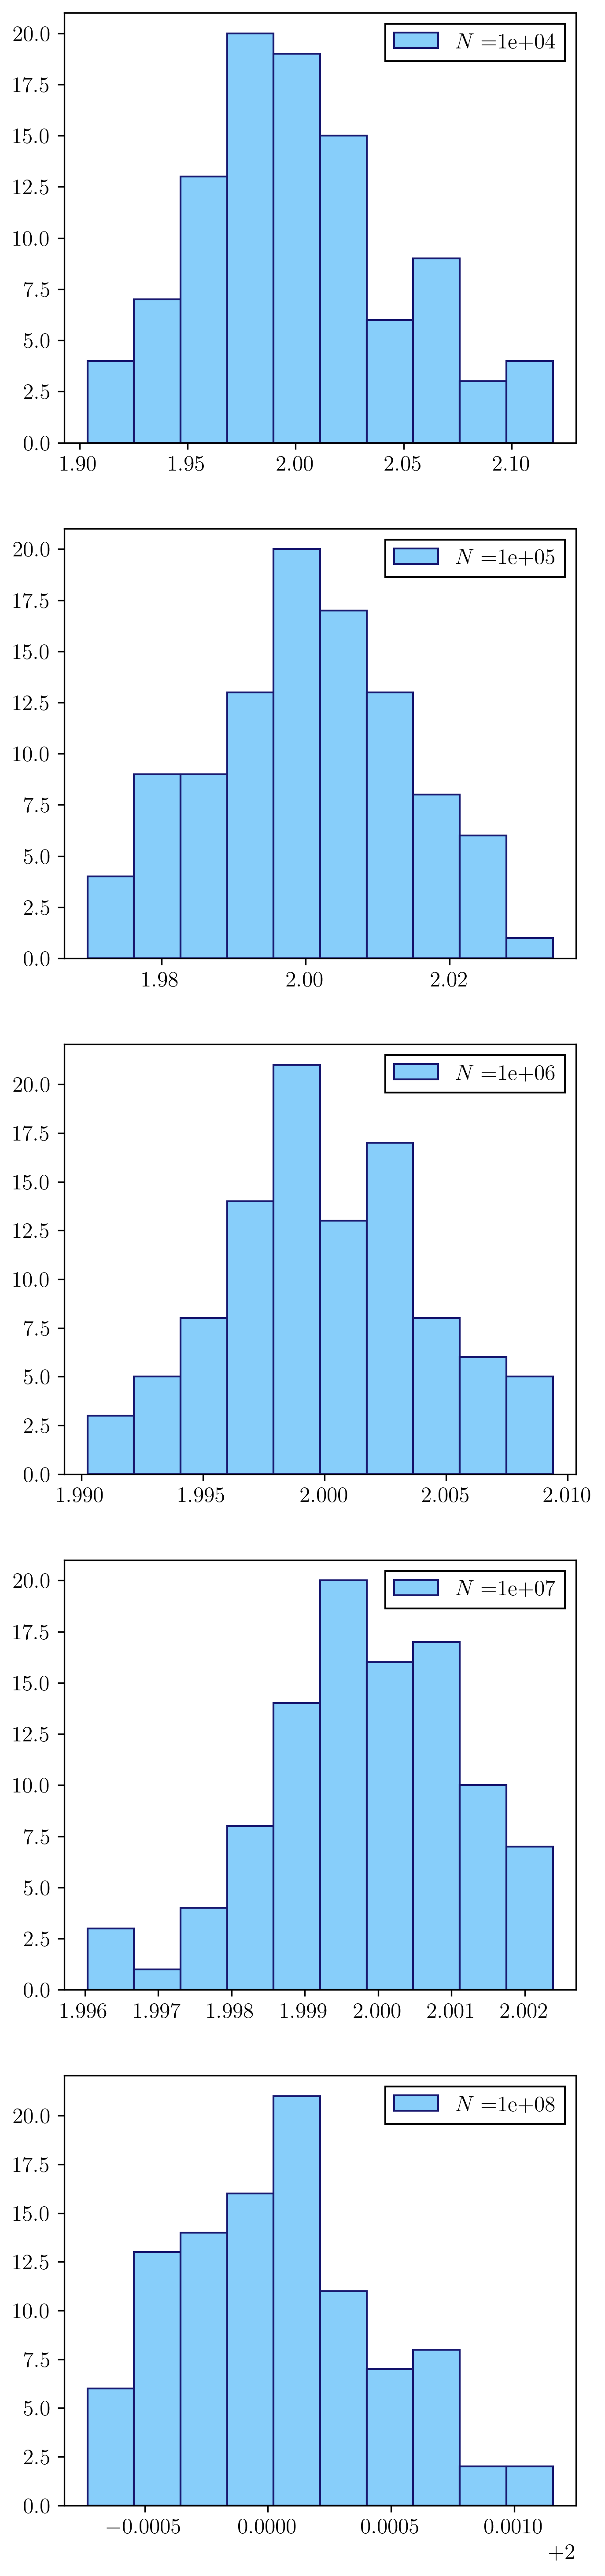

In [8]:
fig , ax = plt.subplots(len(N),1,figsize=(5,25))

for i in range(len(N)):
    ax[i].hist( I_distr[i,:], bins=10, density=False, label='$N = ${:.0e}'.format(float(N[i])), color='lightskyblue', edgecolor='midnightblue')
    ax[i].legend(frameon=True, framealpha=1, fancybox=False, edgecolor='black', loc=1)



In [9]:
'''
Old output (obsolete, now txt)
Analytic integral = 2.0000
N = 1e+04 Monte Carlo integral = 2.0052681104 +- 0.0045353764
N = 1e+05 Monte Carlo integral = 1.9992335076 +- 0.0014049834
N = 1e+06 Monte Carlo integral = 1.9993923738 +- 0.0004578057
N = 1e+07 Monte Carlo integral = 1.9999228544 +- 0.0001450961
'''

'\nOld output (obsolete, now txt)\nAnalytic integral = 2.0000\nN = 1e+04 Monte Carlo integral = 2.0052681104 +- 0.0045353764\nN = 1e+05 Monte Carlo integral = 1.9992335076 +- 0.0014049834\nN = 1e+06 Monte Carlo integral = 1.9993923738 +- 0.0004578057\nN = 1e+07 Monte Carlo integral = 1.9999228544 +- 0.0001450961\n'

sam. mean = 0.610
std. dev. = 0.314
sqrt mean = 0.781


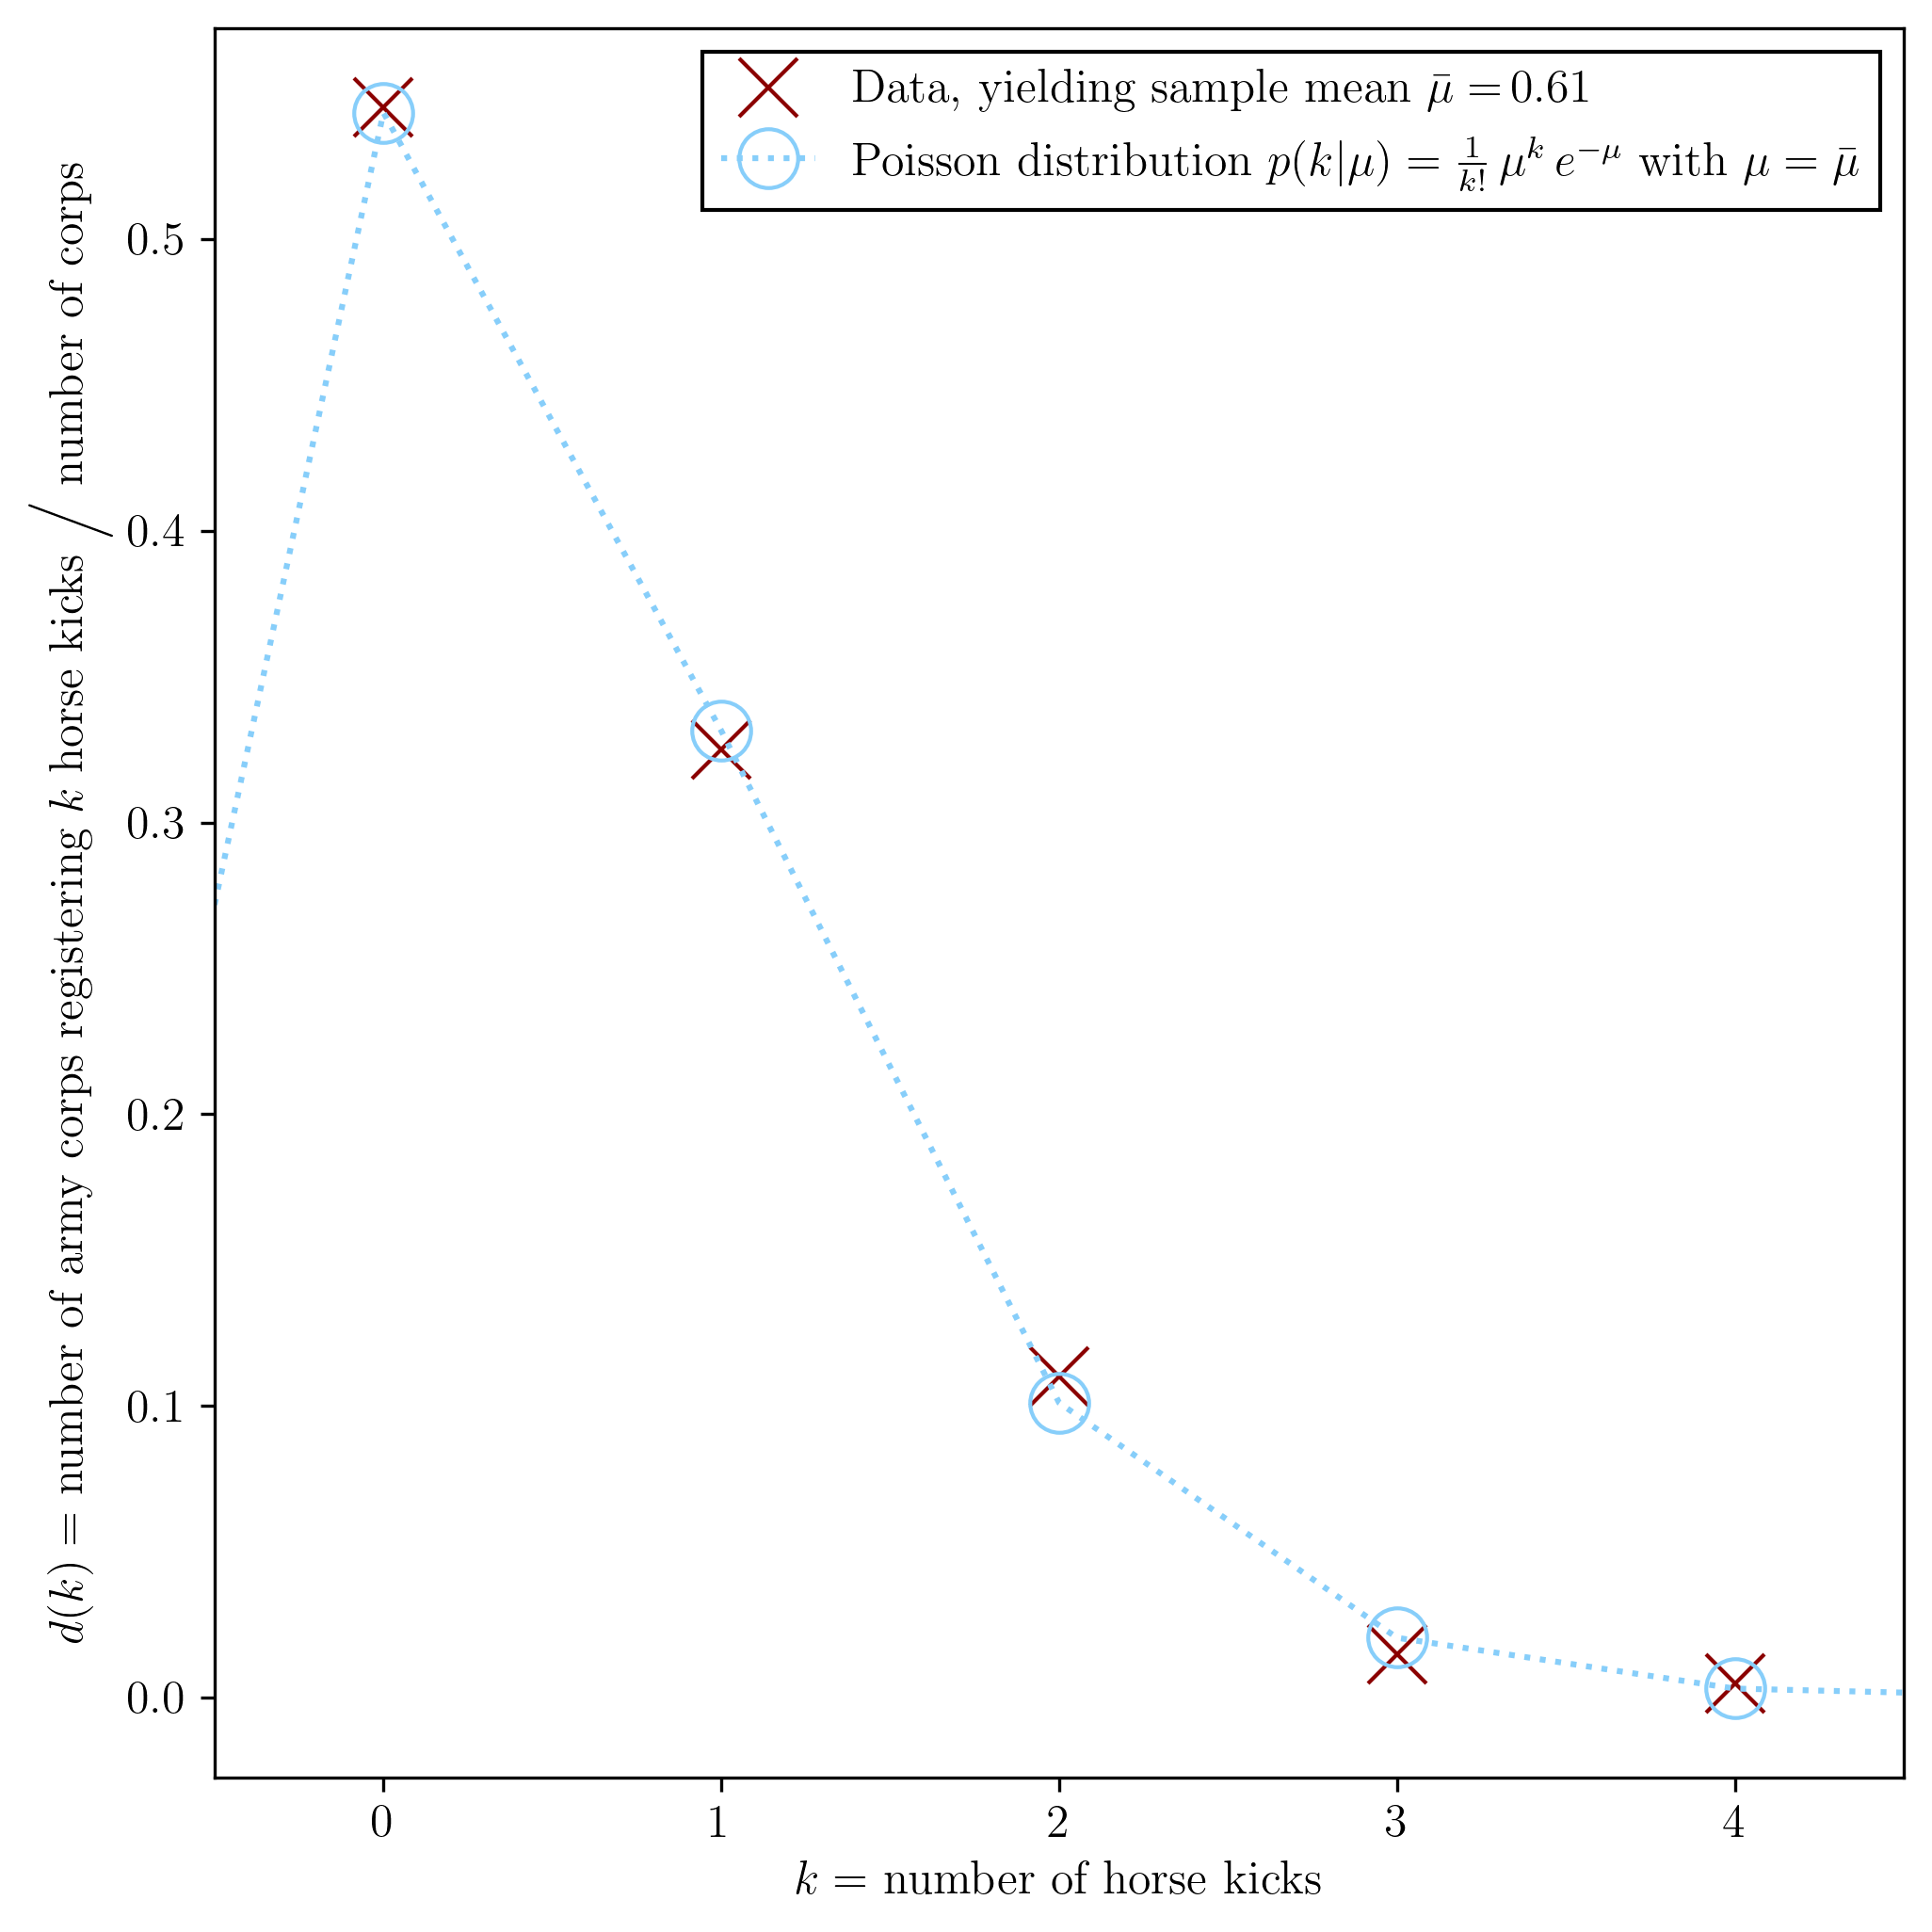

In [10]:
########################################
### L03 - Exercise 2: Kicking Horses ###
########################################

d = np.array( [0, 1, 2, 3, 4] )
c = np.array( [109, 65, 22, 3, 1] )

m = np.sum(d*c) / np.sum(c)
s = np.sqrt( np.sum((d-m)**2) / ( np.sum(c) - 1 ) )

print('sam. mean = {:.3f}'.format(m))
print('std. dev. = {:.3f}'.format(s))
print('sqrt mean = {:.3f}'.format(np.sqrt(m)))


distr_poiss = poisson(m)

x = np.arange(-1,10)
y = distr_poiss.pmf(x)

fig , ax = plt.subplots(1,1, figsize=(7,7))

ax.set_xlim(xmin=-0.5, xmax=4.5)

ax.set_xlabel('$k = $ number of horse kicks')
ax.set_ylabel(r'$d(k) = $ number of army corps registering $k$ horse kicks $\Big/$ number of corps')


data_label = r'Data, yielding sample mean $ \bar{\mu} = \,$' + '{:.2f}'.format(m)

ax.plot( d , c / np.sum(c), linestyle='', marker='x', markersize=15, color='darkred', label=data_label)

poisson_label = r'Poisson distribution $ p(k|\mu) = \frac{1}{k!} \, \mu^k \, e^{-\mu} $ with $ \mu = \bar{\mu} $'

ax.plot(x,y, linestyle=':', color='lightskyblue',marker = 'o', markersize=15 , mfc='none', mec='lightskyblue' , label=poisson_label)


ax.legend(frameon=True, framealpha=1, fancybox=False, edgecolor='black', loc=1)


fig.tight_layout()
fig.savefig('./L03_images/L03_Horse-Kicks.pdf', bbox_inches='tight')







We find that the Poisson distribution $p(k\,|\,\mu)$ is a good approximation for $d(k)$:

$$
    p(k\,|\,\mu) = \frac{1}{k!} \, \mu^k \, e^{-\,\mu}
$$

with $\mu$ taken to be the sample mean $\bar{\mu}$:

$$
    \bar{\mu} = \frac{1}{N} \sum_{i=1}^N \, k_i \, d(k_i)
$$


